# Question
Why are some YouTube channels absent from the Twitter graph?
# Hypothesis
By design, the Twitter graph focus on political tweets (tweets that mention Bolsonaro, Guedes, Moro, and Lula). YouTube favors recommendations outside the political realm.
# Test

Retrieve data from database

In [2]:
library(RSQLite)
con <- dbConnect(drv=RSQLite::SQLite(), dbname=".//youtube_recommendations.sqlite")
recommendation <- dbGetQuery(conn=con, statement="SELECT * FROM recommendation")
dbDisconnect(conn=con)
nrow(recommendation)

[1] 61400

Remove rows where channel_id is NA/NULL

In [3]:
recommendation <- recommendation[complete.cases(recommendation[, c('seed_channel_id','recommended_channel_id')]), ]
nrow(recommendation)

[1] 61295

Remove rows where seed_political_leaning is NA/NULL

In [4]:
recommendation <- recommendation[complete.cases(recommendation[, c('seed_political_leaning')]), ]
nrow(recommendation)

[1] 61033

Create a new column `twitter_graph` that tells if the YouTube channel is present in the Twitter graph

In [5]:
recommendation[['twitter_graph']] <- ifelse(is.na(recommendation$recommended_political_leaning), 'ABSENT', 'PRESENT')
recommendation[['twitter_graph']] <- as.factor(recommendation[['twitter_graph']])
table(recommendation[['twitter_graph']])
round(table(recommendation[['twitter_graph']])/nrow(recommendation),3)
contrasts(recommendation$twitter_graph)


 ABSENT PRESENT 
  12051   48982 


 ABSENT PRESENT 
  0.197   0.803 

,PRESENT
ABSENT,0
PRESENT,1


**20% of the recommendations are absent in the Twitter graph**.

**Therefore, the minimum expected accuracy is very close to 80% (based on the prediction that all YouTube channels are PRESENT in the Twitter graph).**

Convert `char` columns to `factor`

In [6]:
recommendation[['seed_political_leaning']] = as.factor(recommendation[['seed_political_leaning']])
recommendation[['recommended_political_leaning']] = as.factor(recommendation[['recommended_political_leaning']])
recommendation[['category_recommended']] <- as.factor(recommendation[['category_recommended']])

In [7]:
table(recommendation[['category_recommended']])


     Autos & Vehicles                Comedy             Education 
                  122                  1071                  1589 
        Entertainment      Film & Animation                Gaming 
                10989                   559                   164 
        Howto & Style                Movies                 Music 
                   77                     1                   963 
      News & Politics Nonprofits & Activism        People & Blogs 
                30329                   458                 12382 
       Pets & Animals  Science & Technology                Sports 
                  519                   856                   792 
      Travel & Events 
                  162 

There is only one recommendation that belongs to the category `Movie`. It is worth excluding it because it does not improve the model and becomes a hindrance for the regression (for instance, when it is absent from the training set but present in the test set).

In [8]:
recommendation <- recommendation[recommendation$category_recommended != "Movies",]
nrow(recommendation)

[1] 61032

Create train and test sets

In [9]:
set.seed(2)
train <- rep(TRUE, nrow(recommendation))
train[sample.int(length(train), 0.3*nrow(recommendation))] <- FALSE
test <- (!train)

# twitter_graph ~ category_recommended (with intercept)

Let's see if we can increase the accuracy by adding the category of the recommendation.

In [10]:
glm.model <- glm(twitter_graph~category_recommended, data=recommendation[train,], family=binomial)
summary(glm.model)


Call:
glm(formula = twitter_graph ~ category_recommended, family = binomial, 
    data = recommendation[train, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3780   0.3492   0.3492   0.7607   2.8310  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
(Intercept)                                -3.7955     0.7150  -5.308 1.11e-07
category_recommendedComedy                  4.6806     0.7196   6.505 7.78e-11
category_recommendedEducation               3.6688     0.7174   5.114 3.16e-07
category_recommendedEntertainment           4.7180     0.7154   6.595 4.26e-11
category_recommendedFilm & Animation        4.9716     0.7250   6.858 7.00e-12
category_recommendedGaming                 -0.1842     1.0102  -0.182 0.855317
category_recommendedHowto & Style           2.0278     0.8237   2.462 0.013820
category_recommendedMusic                   2.7695     0.7204   3.845 0.000121
category_recommendedNews & Politics         6

**Based on the p-values for most of the categories we can reject the null hypothesis. The category of the recommended videos is useful to predict if a YouTube video's channel will be present in the Twitter graph.**

Now let's see how accurate the results are.

## Training set

In [11]:
glm.probabilities <- predict(glm.model, recommendation[train,], type="response")
recommendation[train, 'predicted'] <- ifelse(glm.probabilities < .5,
                                             levels(recommendation$twitter_graph)[1],
                                             levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[train, 'twitter_graph'], recommendation[train,'predicted'])
classification.table
round(classification.table/nrow(recommendation[train,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT    2325    6128
  PRESENT    999   33271

         
          ABSENT PRESENT
  ABSENT   0.054   0.143
  PRESENT  0.023   0.779

[1] "Accuracy:"


[1] 0.8331812

## Test set

In [12]:
glm.probabilities <- predict(glm.model, recommendation[test,], type="response")
recommendation[test, 'predicted'] <- ifelse(glm.probabilities < .5,
                                            levels(recommendation$twitter_graph)[1],
                                            levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[test, 'twitter_graph'], recommendation[test,'predicted'])
classification.table
round(classification.table/nrow(recommendation[test,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT     973    2624
  PRESENT    428   14284

         
          ABSENT PRESENT
  ABSENT   0.053   0.143
  PRESENT  0.023   0.780

[1] "Accuracy:"


[1] 0.833306

# twitter_graph ~ category_recommended (without intercept)

Which YouTube categories are associated to an increase in the odds of a YouTube channel being present in the Twitter graph?

To answer that question, we can compare the coefficients of the regression.

Since `category_recommended` is a factor, we can remove the intercept in order to:

1. make sure that all the categories appear in the `summary` of the regression (including the "reference" category)
2. make the coefficients comparable between themselves

The idea of removing the intercept was based on [this article](https://www.theanalysisfactor.com/the-impact-of-removing-the-constant-from-a-regression-model-the-categorical-case/) about the meaning of a regression without the intercept.

In [13]:
glm.model <- glm(twitter_graph~category_recommended-1, data=recommendation[train,], family=binomial)
summary(glm.model)


Call:
glm(formula = twitter_graph ~ category_recommended - 1, family = binomial, 
    data = recommendation[train, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.3780   0.3492   0.3492   0.7607   2.8310  

Coefficients:
                                          Estimate Std. Error z value Pr(>|z|)
category_recommendedAutos & Vehicles      -3.79549    0.71499  -5.308 1.11e-07
category_recommendedComedy                 0.88511    0.08106  10.919  < 2e-16
category_recommendedEducation             -0.12671    0.05941  -2.133   0.0329
category_recommendedEntertainment          0.92252    0.02533  36.419  < 2e-16
category_recommendedFilm & Animation       1.17612    0.11991   9.808  < 2e-16
category_recommendedGaming                -3.97968    0.71361  -5.577 2.45e-08
category_recommendedHowto & Style         -1.76766    0.40896  -4.322 1.54e-05
category_recommendedMusic                 -1.02596    0.08785 -11.678  < 2e-16
category_recommendedNews & Politics      

## Training set

In [14]:
glm.probabilities <- predict(glm.model, recommendation[train,], type="response")
recommendation[train, 'predicted'] <- ifelse(glm.probabilities < .5,
                                             levels(recommendation$twitter_graph)[1],
                                             levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[train, 'twitter_graph'], recommendation[train,'predicted'])
classification.table
round(classification.table/nrow(recommendation[train,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT    2325    6128
  PRESENT    999   33271

         
          ABSENT PRESENT
  ABSENT   0.054   0.143
  PRESENT  0.023   0.779

[1] "Accuracy:"


[1] 0.8331812

## Test set

In [15]:
glm.probabilities <- predict(glm.model, recommendation[test,], type="response")
recommendation[test, 'predicted'] <- ifelse(glm.probabilities < .5,
                                            levels(recommendation$twitter_graph)[1],
                                            levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[test, 'twitter_graph'], recommendation[test,'predicted'])
classification.table
round(classification.table/nrow(recommendation[test,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT     973    2624
  PRESENT    428   14284

         
          ABSENT PRESENT
  ABSENT   0.053   0.143
  PRESENT  0.023   0.780

[1] "Accuracy:"


[1] 0.833306

## Discussion

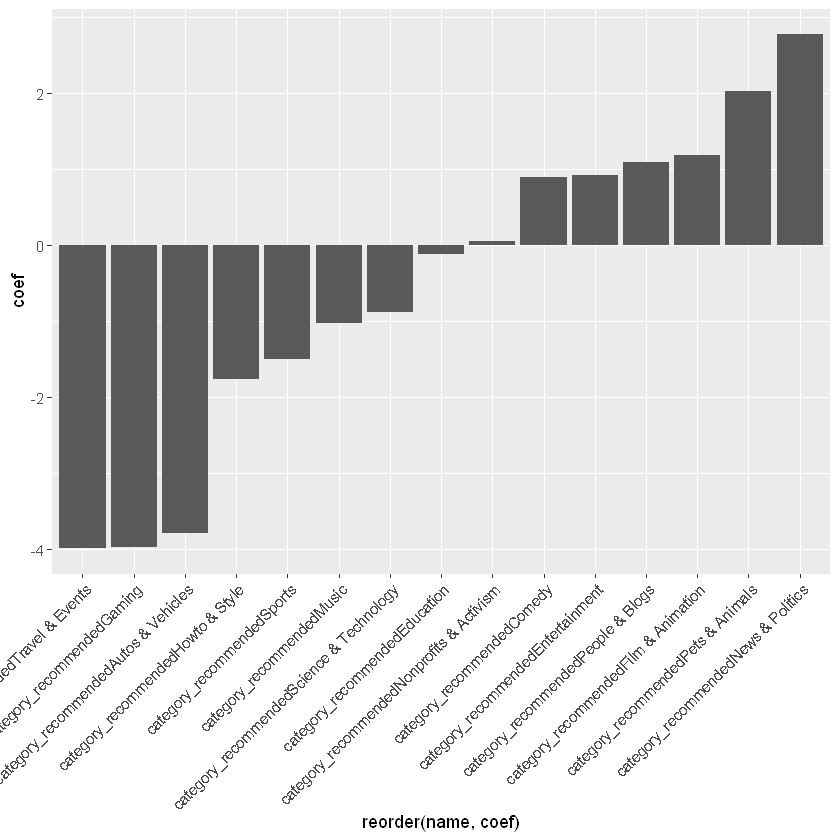

In [16]:
library(ggplot2)
df <- data.frame(name=names(coef(glm.model)), coef=as.numeric(coef(glm.model)))
ggplot(data=df, aes(reorder(name, coef),coef)) +
geom_col() +
theme(axis.text.x=element_text(angle=45,hjust=1))

Based on the p-values of the regression without the intercept, with the exception of `Nonprofits & Activism`, all the other categories seem to be significantly associated with predicting an ABSENT or PRESENT YouTube channel.

What to do about `Nonprofits & Activism`? Probably nothing based on [this StackExchange thread](https://stats.stackexchange.com/questions/24298/can-i-ignore-coefficients-for-non-significant-levels-of-factors-in-a-linear-mode).

These categories are associated with ABSENT channels:
- Travel & Events
- Gaming
- Autos & Vehicles
- Howto & Style
- Sports
- Music
- Science & Technology
- Education (weaker)

And these are associated with channels that are PRESENT in the Twitter graph:
- News & Politics
- Pets & Animals
- Film & Animation
- People & Blogs
- Entertainment
- Comedy

The biggest surprise is the association of `Pets & Animals` with PRESENT (therefore, with channels associated with political content). It is important to investigate.

In [17]:
unique(recommendation[recommendation$category_recommended == 'Pets & Animals' & recommendation$twitter_graph == 'PRESENT', 'recommended_channel_id'])
length(unique(recommendation[recommendation$category_recommended == 'Pets & Animals' & recommendation$twitter_graph == 'PRESENT', 'recommended_channel_id']))

[1] "UCxaJkVoVnpiFhqIO5FQAt4g" "UC5ZXYxeWlROKbL7JziJ0bIQ"
[3] "UCDpw6-Kl_ltcf0AKBA1oKsA" "UCYCVTQfkzIRBOAJfLu980HQ"
[5] "UCToLRq7_OSq17-Arj-bXJmQ" "UCFvREgvwPtIWMlvkvpM5Egw"
[7] "UCiSqmhviFRq35mG_7sYkoIw" "UCJvgqQHu7rbCi-9tiAJ1hyQ"
[9] "UCy3eOZh9n5P3aWWKXmrq6yg"

[1] 9

In [18]:
unique(recommendation[recommendation$category_recommended == 'Pets & Animals' & recommendation$twitter_graph == 'ABSENT', 'recommended_channel_id'])
length(unique(recommendation[recommendation$category_recommended == 'Pets & Animals' & recommendation$twitter_graph == 'ABSENT', 'recommended_channel_id']))

[1] "UCmiaNoZXnzfsa5yfsxaFcnw" "UC3SMLUlhU9F00ovwTEEwRGw"
 [3] "UCF2byDO3lAGUc9YivG2-SpQ" "UChBeA8mF_vtVZ5yeLz3Gs2A"
 [5] "UCBaRsZeCF14e7PEya8Vu4Fg" "UCDb1MVUkr_8kQ4mLfjBorGw"
 [7] "UC3cNsSgH2C8oDw1-aBHmB7A" "UC-eqG9dW9ydhDGs_t67URMg"
 [9] "UC_lPez-npoasT32Jiz3CyJA" "UCOvRZ2NfIW67sEgWlBAB4iQ"
[11] "UCuaDkaHSRoZHVpo8OBvEirQ" "UCqSA9lMsWI23VcpAMZXnOYw"
[13] "UCwmZiChSryoWQCZMIQezgTg" "UCtmBoasiD85ET6GeHJjaFvg"
[15] "UCSs2TVgq_ToPwsuY20s4SAg" "UC4kyYTypYb3mQ6ZL25kly6g"
[17] "UCam6yV3GTsYPWAxu-XIYHqQ" "UC6LDW9--brdKNGF8lpVAHPw"
[19] "UCV0zo6DvLdckCR_PKY5OCpA" "UCLppK3FHqnzNGUwgl3Nvo2g"
[21] "UCC14Fq2GD3dUMj6Pq0qcdlg" "UCdAJa_TUPVEVQacAVrFafuw"
[23] "UCiGOIXjFqy5_mUNxQNOMfHw" "UC2kw0Igf-bx_qAwJNnZiPBg"
[25] "UCpHMCDXxmYSFtk_qv2fwDIQ" "UCHvzeCEIUed7TpzC7nHtL3w"
[27] "UCckS1XjsHd5hMHnSBsRYZMw" "UCyNDOuol6OIKPImq-tmePZQ"
[29] "UC8EOSsUebfHxsmp1KecW93g"

[1] 29

In [19]:
table(recommendation[recommendation$category_recommended == 'Pets & Animals', 'twitter_graph'])
table(recommendation[recommendation$category_recommended == 'Pets & Animals', 'twitter_graph'])/nrow(recommendation[recommendation$category_recommended == 'Pets & Animals', ])


 ABSENT PRESENT 
     54     465 


   ABSENT   PRESENT 
0.1040462 0.8959538 

**Around 90% of recommendations (PRESENT) come from only 9 channels. All those channels were misclassified by their creators as `Pets & Animals`. In fact, they either focus on political content or talk about political topics very frequently. The other 10% of recommendations (ABSENT) come from 29 channels that are correctly identified as `Pets & Animals`.**

In [20]:
table(recommendation[recommendation$category_recommended == 'Film & Animation', 'twitter_graph'])
table(recommendation[recommendation$category_recommended == 'Film & Animation', 'twitter_graph'])/nrow(recommendation[recommendation$category_recommended == 'Film & Animation', ])


 ABSENT PRESENT 
    134     425 


   ABSENT   PRESENT 
0.2397138 0.7602862 

In [21]:
unique(recommendation[recommendation$category_recommended == 'Film & Animation' & recommendation$twitter_graph == 'PRESENT', 'recommended_channel_id'])
length(unique(recommendation[recommendation$category_recommended == 'Film & Animation' & recommendation$twitter_graph == 'PRESENT', 'recommended_channel_id']))

[1] "UCBKBvxZaRWdRYGUgMPfXxjg" "UCEoslUVXeGLIFtyp9ZfnGug"
 [3] "UCC2cGGZOMa8f4GDuSaRX86A" "UCPYIYR0J8ppEJVtR1weLnBw"
 [5] "UCX2M7xn-jMmq4KfX25TCTCA" "UCrQ4fiNiLn1hyPjFf1TjihA"
 [7] "UC4JfQ8DhFAS5wv3VasiS9Ag" "UCSvV1N6IAK3FxZTo0YxuXxQ"
 [9] "UCU_9yd7AqNTToxRpCvhssMg" "UCV2kagEmsbrO5lc6glH-8jA"
[11] "UCkWU59eSRp41W6bCdyJlRdg" "UCv2svvDbMNunUuPs8hUUKVA"
[13] "UCVLMRyUik9KrSdFdfRUiFgg" "UCqdBgTgaWf11tl_V2wa6xNQ"
[15] "UCNId_zjAw2b4Jp7rjL2v4Lw"

[1] 15

In [22]:
unique(recommendation[recommendation$category_recommended == 'Film & Animation' & recommendation$twitter_graph == 'ABSENT', 'recommended_channel_id'])
length(unique(recommendation[recommendation$category_recommended == 'Film & Animation' & recommendation$twitter_graph == 'ABSENT', 'recommended_channel_id']))

[1] "UC75azx7rPcImmpNvIguyDRA" "UC3YchQMt1mWon2YnvsmOasg"
 [3] "UC8PS8EsZsWXOQ1YmlJwCaYw" "UCqaWosAxf_koG94WaiXq27g"
 [5] "UCeCK3Dpmjt14tIDe-lhhO-Q" "UC-Rp7gJdAl0PvRUBjLTFLSg"
 [7] "UCMzpsrLikP9IE5Wqt-c2Aag" "UCKVrZpByd1Z7F073rEcCP1Q"
 [9] "UCQe-nusTPaiBII2tZJBbOmg" "UCXQGKJd_vp2ly6Dm5XgYFWQ"
[11] "UC-j9WQf6n9c81qVDtn-II_Q" "UCYT4J5OxilTQVv6PBjpIIKQ"
[13] "UCYq-iAOSZBvoUxvfzwKIZWA" "UC7UhE9v8aUS3zW7fQFUZfag"
[15] "UCJmi8A0cre-eeonfsFgnXKw" "UCcSCH8sMQ-oL9028xs5UgTg"
[17] "UCMkfplx8TFPlINxcXLXL0KQ" "UCoDBW9MUSMhhjrPxhxLyT1A"
[19] "UCBy64MAeyjbPn9m12r6x-TQ" "UC_ZyQ5Z1b2ZNMOZmwp6_DPg"
[21] "UC2eb58Gxb613nJDjpuwWmgg" "UCC7ElkFVK3m03gEMfaq6Ung"
[23] "UCCtkj3NZl5v8TDMtDr7LDag" "UCytNlgCf5kfL8iS6OGgkKYQ"
[25] "UCd8z3gfB0ZUnZNq5Di5t1QA" "UCp-ZlVc-lJ7MrdlzMOJU36g"
[27] "UCQb__wEpi5q8_xhkuk2jm5g" "UC61CPbjIcb8AredRR_Y94TA"
[29] "UCWwicwAwBS0ocAJr2-yhKDQ" "UCd8J_aeX6_AaoZOG9QKffrw"
[31] "UCYYcZWo9Am705B9P-lno5tA" "UCK4dOs3ln_BSotkdhK5dzOw"
[33] "UCeCNJFVFZrbeQA-wfTMchqg" "UCKCaTZ3S6G_HqXlrflzX3WQ"
[35] "UCE70RrYW1i7RaiLQCKkdUIQ" "UCOxKYSITnM7Pt-yMXcNYrGg"
[37] "UCcFoPzfCXeTsTRDrL46vLNg" "UC_SRQEScGB2ZdO6hZlmBUlw"
[39] "UCWjz-o1Shh7SfcyZm0LdrTQ" "UChyEFtvkuRC_E93FZgVbj9g"
[41] "UC4DeKBDTzFyj2rBCHEsvFkQ" "UC-GAhNmY6bkuuRPUSaRI_oQ"
[43] "UCq3HBedsWI5NU1G3Oe8YS6A" "UCqmL6CcFIOZKLDQ1W45ur_A"
[45] "UCHSkSVGsdabMFZ7ZkNSxo4A" "UCJ1T27qfdN7k7Fqpn2CwJGw"
[47] "UC7U72Ze-y8s4hvAmRvhXPgQ" "UCKgei5VNEBfwprLT1_6qFXA"
[49] "UCUMH1HswYrQqjxPYGIxtOtA" "UCuBUgg6aDGH2kZZDyNQx3AQ"
[51] "UCuMS9Ge1phL958rkHtQRH-A" "UCPk29gUc_ltOGQ6f3Lh5kCg"
[53] "UCCYCzL7IuMho0bHYYJ3Cuyw" "UCgRi4z6xTdB9fAJKYLLAKdg"
[55] "UCkgs3mnbrvj_6SH17WB7s9g"

[1] 55

**Something similar happened to the category `Film & Animation`.**

# Other predictors

It is worth checking if other predictors also influence if a recommendation is PRESENT or ABSENT in the Twitter graph.

In [23]:
recommendation[['category_seed']] <- as.factor(recommendation[['category_seed']])

In [24]:
glm.model <- glm(twitter_graph~category_seed, data=recommendation[train,], family=binomial)
summary(glm.model)


Call:
glm(formula = twitter_graph ~ category_seed, family = binomial, 
    data = recommendation[train, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0741   0.6458   0.6458   0.6607   1.4823  

Coefficients:
                                   Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         1.05486    0.11122   9.485  < 2e-16 ***
category_seedEducation             -0.04933    0.14369  -0.343 0.731350    
category_seedEntertainment          0.35597    0.11579   3.074 0.002110 ** 
category_seedFilm & Animation      -0.06888    0.16286  -0.423 0.672326    
category_seedGaming                -1.74800    1.22978  -1.421 0.155204    
category_seedMusic                 -0.97689    0.19592  -4.986 6.15e-07 ***
category_seedNews & Politics        0.40674    0.11239   3.619 0.000296 ***
category_seedNonprofits & Activism -0.67144    0.16758  -4.007 6.16e-05 ***
category_seedPeople & Blogs         0.29541    0.11409   2.589 0.009619 ** 
cat

In [25]:
glm.probabilities <- predict(glm.model, recommendation[train,], type="response")
recommendation[train, 'predicted'] <- ifelse(glm.probabilities < .5,
                                             levels(recommendation$twitter_graph)[1],
                                             levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[train, 'twitter_graph'], recommendation[train,'predicted'])
classification.table
round(classification.table/nrow(recommendation[train,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT       2    8451
  PRESENT      1   34269

         
          ABSENT PRESENT
  ABSENT   0.000   0.198
  PRESENT  0.000   0.802

[1] "Accuracy:"


[1] 0.8021675

**`category_seed` is not better than intercept only.**

In [43]:
# convert to date when appropriate
recommendation[['recommendation_date']] <- as.Date(recommendation[['recommendation_date']])
recommendation[['recommended_published_at']] <- as.Date(recommendation[['recommended_published_at']])
recommendation[['age_in_days']] <- as.numeric(recommendation[['recommendation_date']] - recommendation[['recommended_published_at']])

In [44]:
glm.model <- glm(twitter_graph~age_in_days, data=recommendation[train,], family=binomial)
summary(glm.model)


Call:
glm(formula = twitter_graph ~ age_in_days, family = binomial, 
    data = recommendation[train, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0192   0.5286   0.5290   0.5321   2.8701  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  1.899e+00  1.538e-02   123.5   <2e-16 ***
age_in_days -1.555e-03  2.382e-05   -65.3   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 42502  on 42722  degrees of freedom
Residual deviance: 36714  on 42721  degrees of freedom
AIC: 36718

Number of Fisher Scoring iterations: 4


**Training set:**

In [45]:
glm.probabilities <- predict(glm.model, recommendation[train,], type="response")
recommendation[train, 'predicted'] <- ifelse(glm.probabilities < .5,
                                             levels(recommendation$twitter_graph)[1],
                                             levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[train, 'twitter_graph'], recommendation[train,'predicted'])
classification.table
round(classification.table/nrow(recommendation[train,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT    1925    6528
  PRESENT   1094   33176

         
          ABSENT PRESENT
  ABSENT   0.045   0.153
  PRESENT  0.026   0.777

[1] "Accuracy:"


[1] 0.8215949

**Test set:**

In [46]:
glm.probabilities <- predict(glm.model, recommendation[test,], type="response")
recommendation[test, 'predicted'] <- ifelse(glm.probabilities < .5,
                                            levels(recommendation$twitter_graph)[1],
                                            levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[test, 'twitter_graph'], recommendation[test,'predicted'])
classification.table
round(classification.table/nrow(recommendation[test,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT     830    2767
  PRESENT    517   14195

         
          ABSENT PRESENT
  ABSENT   0.045   0.151
  PRESENT  0.028   0.775

[1] "Accuracy:"


[1] 0.8206347

**Why do 11 recommendations have negative `age_in_days`?**

In [88]:
recommendation[recommendation$age_in_days < 0, ]

,recommendation_date,seed_video_id,seed_published_at,seed_channel_id,category_seed,recommended_video_id,recommended_published_at,recommended_channel_id,category_recommended,rank,...,recommended_video_count,seed_cumulative_video_count,recommended_cumulative_video_count,seed_comment_count,recommended_comment_count,seed_cumulative_comment_count,recommended_cumulative_comment_count,twitter_graph,predicted,age_in_days
,<date>,<chr>,<chr>,<chr>,<fct>,<chr>,<date>,<chr>,<fct>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<chr>,<dbl>
6224,2019-11-20,iXgizwidctM,2019-11-17 20:01:36.000,UC65OaKMLtpEUs9BiLSb_u1g,News & Politics,ouaJAyolV6I,2019-11-21,UC65OaKMLtpEUs9BiLSb_u1g,News & Politics,1,...,2,1620,1620,0,0,0,0,PRESENT,PRESENT,-1
18789,2019-11-20,AHtjgip-gG8,2019-11-14 17:37:55.000,UCYiM773ssvNMaBHvaWWeIoQ,People & Blogs,F9a7OVPZESc,2019-11-21,UCYiM773ssvNMaBHvaWWeIoQ,People & Blogs,1,...,19,6778,6778,0,0,0,0,PRESENT,PRESENT,-1
18790,2019-11-20,UruJ0sZjp1Q,2019-11-18 00:34:25.000,UCYiM773ssvNMaBHvaWWeIoQ,People & Blogs,F9a7OVPZESc,2019-11-21,UCYiM773ssvNMaBHvaWWeIoQ,People & Blogs,1,...,19,6778,6778,0,0,0,0,PRESENT,PRESENT,-1
33090,2020-02-01,spDfb-yF8z0,2020-01-29 23:27:29.000,UCBrntWupyTRnnsRy3dA4VdA,Education,h9xzJo9rWRI,2020-02-02,UCBrntWupyTRnnsRy3dA4VdA,Education,4,...,1,547,547,0,0,0,0,PRESENT,PRESENT,-1
33474,2019-11-10,gNfVPy5VS04,2019-11-08 16:20:15.000,UC8DhN1cJi0QklBQot5hv_kg,Education,AGodCvs5CK8,2019-11-11,UCWwZ0vM0qnr3vPHh2lgqH_w,News & Politics,5,...,NA,NA,NA,NA,NA,NA,NA,ABSENT,PRESENT,-1
35081,2019-11-10,V0VvqvOtCMA,2019-11-10 20:51:14.000,UCsF4dJCnS72iHzFPvpdhpNA,News & Politics,4IL8YjANz5M,2019-11-11,UCsF4dJCnS72iHzFPvpdhpNA,News & Politics,2,...,0,12,12,0,0,0,0,PRESENT,PRESENT,-1
35822,2020-02-01,Fug5kl_FQPk,2020-01-30 15:47:08.000,UCC6f63SXY0CDpsPGDBtTWVg,News & Politics,mN8nAnUEJt0,2020-02-02,UCVFbXI6Gu8U2f9Gjtxw4A-Q,News & Politics,9,...,0,1302,2171,0,0,0,0,PRESENT,PRESENT,-1
39514,2019-11-09,4yWlrQRoJro,2019-11-07 11:34:47.000,UCRuy5PigeeBuecKnwqhM4yg,News & Politics,9kPDYO18YLo,2019-11-11,UC-wcdrzucnlKGBjyEUaEWaQ,Entertainment,8,...,8,9806,6743,0,0,0,0,PRESENT,PRESENT,-2
42514,2019-11-10,gNfVPy5VS04,2019-11-08 16:20:15.000,UC8DhN1cJi0QklBQot5hv_kg,Education,abO2z2Ff3XM,2019-11-11,UC8DhN1cJi0QklBQot5hv_kg,Education,3,...,NA,NA,NA,NA,NA,NA,NA,PRESENT,PRESENT,-1


In [89]:
unique(recommendation[recommendation$age_in_days < 0, c('recommendation_date', 'recommended_published_at')])

,recommendation_date,recommended_published_at
,<date>,<date>
6224,2019-11-20,2019-11-21
33090,2020-02-01,2020-02-02
33474,2019-11-10,2019-11-11
39514,2019-11-09,2019-11-11


**They are restricted to three publication dates: 2019-11-11, 2019-11-21, and 2020-02-02. They are also only 11 records. For that reason, it is not worth investigating further.**

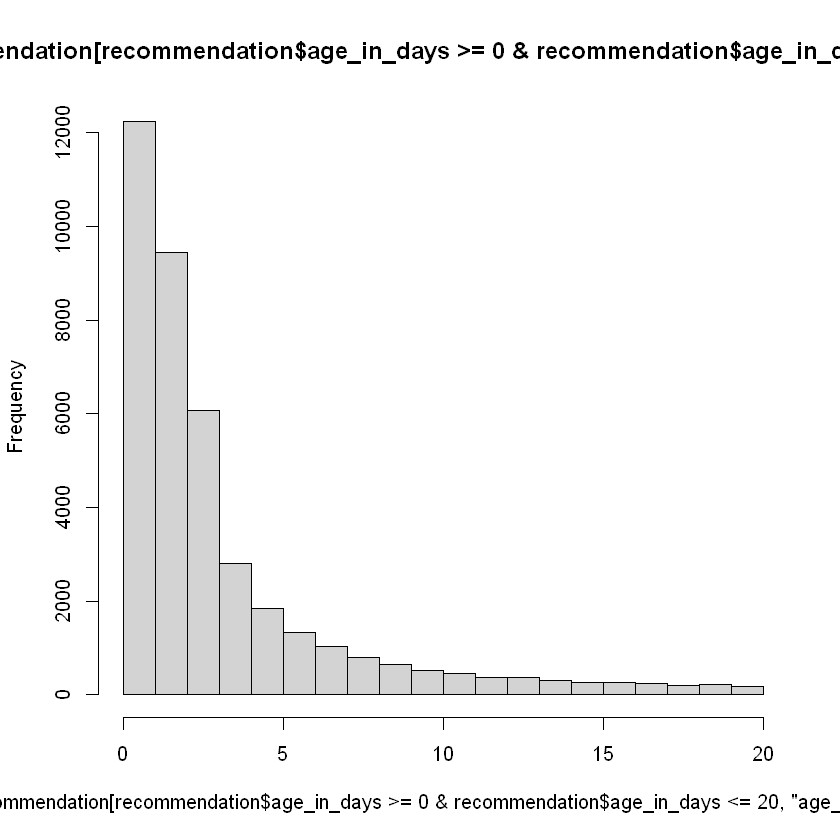

In [94]:
hist(recommendation[recommendation$age_in_days >= 0 & recommendation$age_in_days <= 20, 'age_in_days'])

**Expected behavior: newer videos are recommended more frequently.**

**What is the meaning of the coefficient?**

In [90]:
contrasts(recommendation$twitter_graph)

,PRESENT
ABSENT,0
PRESENT,1


The coefficient is negative. Therefore, the odds of a recommendation being PRESENT in the Twitter_graph is inversely proportional to the age in days. **Older videos tend to be ABSENT in the `twitter_graph`.**

In [99]:
glm.model <- glm(twitter_graph~category_recommended*age_in_days, data=recommendation[train,], family=binomial)
summary(glm.model)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = twitter_graph ~ category_recommended * age_in_days, 
    family = binomial, data = recommendation[train, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.5061   0.2976   0.2983   0.5272   4.2228  

Coefficients:
                                                        Estimate Std. Error
(Intercept)                                           -3.9991602  0.9402838
category_recommendedComedy                             5.3322056  0.9458258
category_recommendedEducation                          4.1732652  0.9428958
category_recommendedEntertainment                      5.2825655  0.9408108
category_recommendedFilm & Animation                   5.7938930  0.9536716
category_recommendedGaming                             1.1424346  1.2159175
category_recommendedHowto & Style                      2.8418605  1.0748916
category_recommendedMusic                              4.3238721  0.9490597
category_recommendedNews & Politics                    7.0

In [100]:
glm.probabilities <- predict(glm.model, recommendation[train,], type="response")
recommendation[train, 'predicted'] <- ifelse(glm.probabilities < .5,
                                             levels(recommendation$twitter_graph)[1],
                                             levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[train, 'twitter_graph'], recommendation[train,'predicted'])
classification.table
round(classification.table/nrow(recommendation[train,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT    3609    4844
  PRESENT    969   33301

         
          ABSENT PRESENT
  ABSENT   0.084   0.113
  PRESENT  0.023   0.779

[1] "Accuracy:"


[1] 0.8639375

In [157]:
glm.probabilities <- predict(glm.model, recommendation[test,], type="response")
recommendation[test, 'predicted'] <- ifelse(glm.probabilities < .5,
                                            levels(recommendation$twitter_graph)[1],
                                            levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[test, 'twitter_graph'], recommendation[test,'predicted'])
classification.table
round(classification.table/nrow(recommendation[test,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          ABSENT PRESENT
  ABSENT    1560    2037
  PRESENT    444   14268

         
          ABSENT PRESENT
  ABSENT   0.085   0.111
  PRESENT  0.024   0.779

[1] "Accuracy:"


[1] 0.8644929

Let's investigate error **"glm.fit: fitted probabilities numerically 0 or 1 occurred"**.

In [137]:
max(glm.probabilities)

[1] 0.9581381

In [138]:
min(glm.probabilities)

[1] 2.220446e-16

The warning was prompted by probabilities very close to 0. Let's see who they are.

In [156]:
recommendation_aux = recommendation[train, ]
recommendation_aux[glm.probabilities < 0.0000000000000003, c('category_seed', 'category_recommended', 'age_in_days', 'twitter_graph', 'predicted')]

,category_seed,category_recommended,age_in_days,twitter_graph,predicted
,<fct>,<fct>,<dbl>,<fct>,<chr>
34,News & Politics,Pets & Animals,3755,ABSENT,ABSENT
2766,News & Politics,Gaming,916,ABSENT,ABSENT
3547,News & Politics,Gaming,921,ABSENT,ABSENT
4132,News & Politics,Gaming,934,ABSENT,ABSENT
5268,News & Politics,Gaming,893,ABSENT,ABSENT
5270,News & Politics,Gaming,893,ABSENT,ABSENT
5638,News & Politics,Gaming,900,ABSENT,ABSENT
6448,News & Politics,Gaming,911,ABSENT,ABSENT
6451,News & Politics,Gaming,923,ABSENT,ABSENT


There is no need to worry about the warning. The model is correctly predicting that old videos from non-political categories are certainly ABSENT in the Twitter graph. `Pets & Animals` is mentioned here but all the recommendations are very old.

**The interaction of `age_in_days` and `category_recommended` increased the accuracy of the model.**

**Does political leaning of seed video matter? Do right-wing seed videos tend to be followed by UNKNOWN recommendations? What about left-wing seed videos?**

In [158]:
glm.model <- glm(twitter_graph~seed_political_leaning, data=recommendation[train,], family=binomial)
summary(glm.model)


Call:
glm(formula = twitter_graph ~ seed_political_leaning, family = binomial, 
    data = recommendation[train, ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8964   0.6017   0.6873   0.6873   0.6873  

Coefficients:
                            Estimate Std. Error z value Pr(>|z|)    
(Intercept)                  1.61719    0.02461   65.72   <2e-16 ***
seed_political_leaningRIGHT -0.29459    0.02831  -10.41   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 42502  on 42722  degrees of freedom
Residual deviance: 42390  on 42721  degrees of freedom
AIC: 42394

Number of Fisher Scoring iterations: 4


In [189]:
glm.probabilities <- predict(glm.model, recommendation[train,], type="response")
recommendation[train, 'predicted'] <- ifelse(glm.probabilities < 0.5,
                                             levels(recommendation$twitter_graph)[1],
                                             levels(recommendation$twitter_graph)[2])
classification.table <- table(recommendation[train, 'twitter_graph'], recommendation[train,'predicted'])
classification.table
round(classification.table/nrow(recommendation[train,]),3)
print('Accuracy:')
sum(diag(classification.table))/sum(classification.table)

         
          PRESENT
  ABSENT     8453
  PRESENT   34270

         
          PRESENT
  ABSENT    0.198
  PRESENT   0.802

[1] "Accuracy:"


[1] 0.197856

In [180]:
min(glm.probabilities)

[1] 0.7896139

In [181]:
max(glm.probabilities)

[1] 0.8344072

Interestingly, the probability of being PRESENT is very close to 80%.

**This seems to be a case in which [a significant variable is also a useless predictor](https://towardsdatascience.com/why-models-with-significant-variables-can-be-useless-predictors-3354722a4c05). There is also a very interesting discussion on this topic [in this thread](https://stats.stackexchange.com/questions/1194/practical-thoughts-on-explanatory-vs-predictive-modeling).**

**One can hypothesize that the lower its rank (closer to 1), the likelier a YouTube channel is present in the Twitter graph. Let's see if that's the case.**

In [251]:
glm.model <- glm(twitter_graph~rank, data=recommendation[train,], family=binomial)
summary(glm.model)


Call:
glm(formula = twitter_graph ~ rank, family = binomial, data = recommendation[train, 
    ])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8172   0.6527   0.6602   0.6677   0.6754  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 1.353521   0.026091  51.877   <2e-16 ***
rank        0.008454   0.004239   1.994   0.0461 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 42502  on 42722  degrees of freedom
Residual deviance: 42498  on 42721  degrees of freedom
AIC: 42502

Number of Fisher Scoring iterations: 4


**The significance seems to be week (p=0.0461). And it goes in the wrong direction: the higher its rank, the likelier a YouTube channel is present in the Twitter graph.**